Importing stuff

In [1]:
import torch
import torchaudio
from datasets import load_metric, Dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2ProcessorWithLM
import kenlm
from pyctcdecode import build_ctcdecoder
from IPython.display import Audio
from pathlib import Path
import json

vad_model, vad_utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = vad_utils

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/peterr/.cache/torch/hub/master.zip


In [2]:
wav = read_audio(f'audio/s1iBR07bVrg_clipped.wav', sampling_rate=16000)
vad_ts=get_speech_timestamps(wav, vad_model, sampling_rate=16000, speech_pad_ms=1000, return_seconds=True)
print(f'Found {len(vad_ts)} segments')

Found 216 segments


In [3]:
from numpy import ceil


def resample(ts, max_gap=3, max_len=30):
    for s in ts:
        if s["end"] - s["start"] > max_len:
            print(
                f"Error: max_len ({max_len}) is smaller than one of the segments ({s})!"
            )
            return None
    gts = []
    g = [ts[0]]
    for s in ts[1:]:
        if s["start"] - g[-1]["end"] < max_gap:
            g.append(s)
        else:
            gts.append(g)
            g = [s]
    gts.append(g)
    ret = []
    for g in gts:
        l = g[-1]["end"] - g[0]["start"]
        split_num = ceil(l / max_len)
        if split_num > 1:
            min_len = l / split_num
            start = g[0]["start"]
            end = g[0]["end"]
            for s in g[1:]:
                if s["end"] - start > max_len or end - start > min_len:
                    ret.append({"start": start, "end": end})
                    start = s["start"]
                    end = s["end"]
                else:
                    end = s["end"]
            ret.append({"start": start, "end": end})
        else:
            ret.append({"start": g[0]["start"], "end": g[-1]["end"]})
    return ret
ts=resample(vad_ts)
print(f'Found {len(ts)} segments')
print(ts)

Found 42 segments
[{'start': 0.2, 'end': 18.3}, {'start': 18.3, 'end': 43.2}, {'start': 43.2, 'end': 71.6}, {'start': 71.6, 'end': 98.5}, {'start': 98.5, 'end': 122.4}, {'start': 122.4, 'end': 140.9}, {'start': 140.9, 'end': 170.1}, {'start': 170.1, 'end': 198.8}, {'start': 198.8, 'end': 226.7}, {'start': 226.7, 'end': 253.2}, {'start': 253.9, 'end': 278.9}, {'start': 278.9, 'end': 307.2}, {'start': 307.2, 'end': 330.4}, {'start': 330.4, 'end': 356.2}, {'start': 356.2, 'end': 384.7}, {'start': 384.7, 'end': 414.5}, {'start': 414.5, 'end': 439.1}, {'start': 439.1, 'end': 467.0}, {'start': 467.0, 'end': 494.5}, {'start': 494.5, 'end': 520.9}, {'start': 522.4, 'end': 547.8}, {'start': 547.8, 'end': 576.1}, {'start': 576.1, 'end': 600.8}, {'start': 600.8, 'end': 630.6}, {'start': 630.6, 'end': 659.8}, {'start': 659.8, 'end': 688.2}, {'start': 688.2, 'end': 713.6}, {'start': 713.6, 'end': 742.4}, {'start': 742.4, 'end': 767.4}, {'start': 767.4, 'end': 794.4}, {'start': 794.4, 'end': 823.6},

In [4]:
from numpy import linspace, zeros, logical_and

wav_data = wav.numpy()
T = wav_data.size / 16000.0
t = linspace(0, T, wav_data.size)


sil = zeros(10 * (int(T) + 1))  # 10 pts per second
sil_x = linspace(0, T, sil.size)

for n, tx in enumerate(ts):
    m = logical_and(sil_x >= tx["start"], sil_x <= tx["end"])
    sil[m] = (n & 1) + 1


(0.0, 90.0)

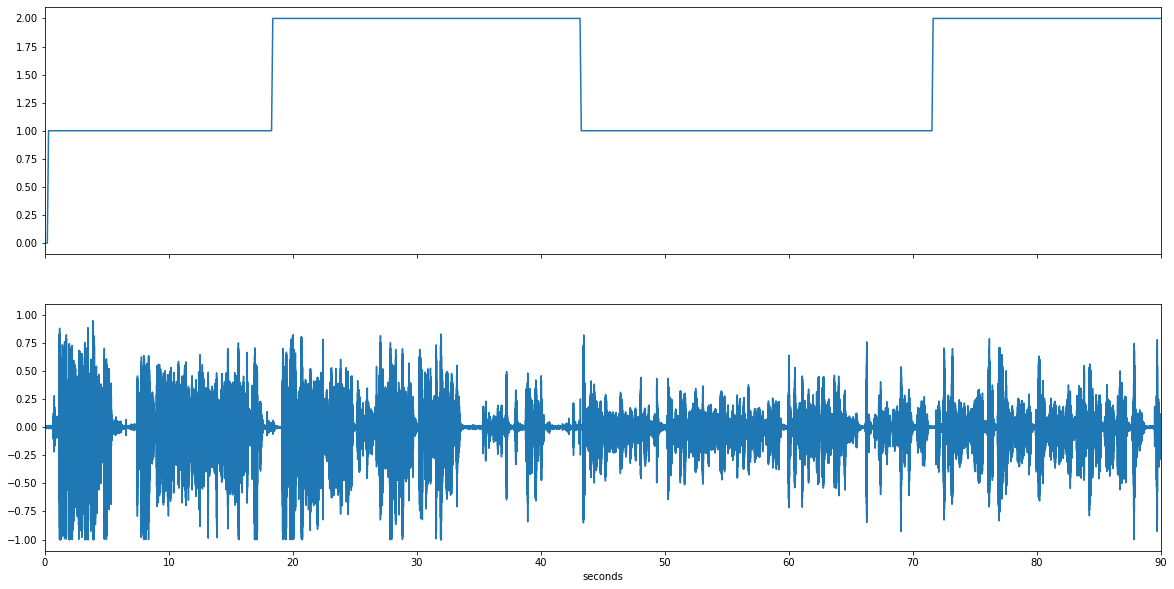

In [5]:
from matplotlib.pyplot import subplots, xlabel, xlim
fig,ax=subplots(2,1,sharex=True,figsize=(20,10))
ax[0].plot(sil_x,sil)
ax[1].plot(t,wav_data)
xlabel('seconds')
xlim(0,90)

In [6]:
model_name = "classla/wav2vec2-xls-r-parlaspeech-hr"
device = "cuda"

model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(model_name)

sampling_rate = 16000

files = {"sample": Path("audio/s1iBR07bVrg_clipped.wav")}

ds_dict = {"file": [], "start": [], "end": []}
for seg in ts:
    ds_dict["file"].append("sample")
    ds_dict["start"].append(seg["start"])
    ds_dict["end"].append(seg["end"])
ds = Dataset.from_dict(ds_dict)

wavcache = {}


def map_to_array(batch):
    if batch["file"] in wavcache:
        speech = wavcache[batch["file"]]
    else:
        path = files[batch["file"]]
        speech, _ = torchaudio.load(path)
        speech = speech.squeeze(0).numpy()
        wavcache[batch["file"]] = speech
    sstart = int(batch["start"] * sampling_rate)
    send = int(batch["end"] * sampling_rate)
    batch["speech"] = speech[sstart:send]
    return batch


ds = ds.map(map_to_array)


def map_to_pred(batch):
    features = processor(
        batch["speech"], sampling_rate=sampling_rate, padding=True, return_tensors="pt"
    )
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
    pred_ids = torch.argmax(logits, dim=-1)
    batch["predicted"] = processor.batch_decode(pred_ids)
    return batch


result = ds.map(map_to_pred, batched=True, batch_size=8)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [7]:
result['predicted']

['konačni prijedlog zakona o izmjenama i dopunama zakona o pravu na pristup informacijama to je prijedlog zakona br 199to nije u drugom čitanju sa svim karakteristikama koje imaju zakon u drugom čitanju značaj amandmani se mogu podninuti do kraja rasprave',
 'raspravu su provedio odbor za zakonodavstvo i odbor za ustav poslovnik politički sustav odbor za informiranje informacije i medija znači t odbora žuli li predstavnik predlagatelja održavni tajnik gospodin juro martinević iz ministarstva pravosuđa i uprave uzeti riječss stanka stanka gje vi izvolite gospođo oreškovi stanka',
 'hvala predsjedavatelju tražim stanku u ime kluba stranke centar i stranke i glasa trajanju od 10 minuta radi dodatnih konzultacija naime prije svega želim ukazati na činjenicu da je u ovom trenu praktički prazna sabornica da je prisutno svega 10tak saborskih zastupnika i to uoči početka rasprave o jednom od najvažnijih antikorupcijskih zakonaae',
 'dakle radi se o zakonu koji je ishodište početak svakog prava

In [11]:
result.column_names

['file', 'start', 'end', 'speech', 'predicted']

In [12]:
result["start"]

[0.2,
 18.3,
 43.2,
 71.6,
 98.5,
 122.4,
 140.9,
 170.1,
 198.8,
 226.7,
 253.9,
 278.9,
 307.2,
 330.4,
 356.2,
 384.7,
 414.5,
 439.1,
 467.0,
 494.5,
 522.4,
 547.8,
 576.1,
 600.8,
 630.6,
 659.8,
 688.2,
 713.6,
 742.4,
 767.4,
 794.4,
 823.9,
 836.3,
 860.7,
 877.7,
 907.1,
 936.8,
 963.9,
 990.7,
 1011.9,
 1040.4,
 1069.9]

Constructing a wrapper for a single file:

In [1]:
from utils import process_file

process_file("audio_2.wav")

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/peterr/.cache/torch/hub/master.zip
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/66 [00:00<?, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

,file,start,end,predicted
0,audio_2.wav,6.2,9.0,temiteibinteea
1,audio_2.wav,12.3,15.6,omoopoormopo
2,audio_2.wav,20.3,45.9,upoznato meselji u ruskoj izvanjednoj dajceni ...
3,audio_2.wav,45.9,73.3,sve ideje koje nalazimo ne samo što su izrasle...
4,audio_2.wav,73.3,103.2,već kako je to pokazao anže walitcki i na idej...
...,...,...,...,...
61,audio_2.wav,1667.0,1696.2,koju mora da razume da objasni nijedan istorič...
62,audio_2.wav,1696.2,1723.4,a mi smo naprednjake počeli da radimo tek od 2...
63,audio_2.wav,1723.4,1752.8,i zanimljivo je ta alternativa moderna europsk...
64,audio_2.wav,1752.8,1773.9,da su šanse ne kažem nade ali šanse za to da s...


Doing it on whole Južne Vesti corpus:

In [3]:
import pandas as pd
from tqdm.auto import tqdm
corpus = pd.read_csv("006_crawling_juznevesti.csv")
dfs = []
for i in tqdm(corpus.path):
    try:
        dfs.append(process_file(i))
    except:
        pass
df = pd.concat(dfs, ignore_index=True)

df.to_csv("011_segments.csv", index=False)

  0%|          | 0/299 [00:00<?, ?it/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 126.9, 'end': 160.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/31 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 151.2, 'end': 181.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 579.7, 'end': 612.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/62 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 684.0, 'end': 714.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 729.3, 'end': 760.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 97.7, 'end': 145.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 252.4, 'end': 289.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 192.7, 'end': 228.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 96.1, 'end': 127.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 187.9, 'end': 242.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 129.6, 'end': 163.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 778.2, 'end': 809.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 101.9, 'end': 138.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/31 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 108.9, 'end': 139.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 114.8, 'end': 147.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 119.8, 'end': 158.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 92.3, 'end': 129.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/43 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 73.9, 'end': 107.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 714.1, 'end': 753.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/48 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 76.0, 'end': 127.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 700.8, 'end': 739.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 594.9, 'end': 626.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 401.6, 'end': 433.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 313.1, 'end': 355.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/41 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/39 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 360.8, 'end': 394.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/43 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 218.4, 'end': 278.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 845.9, 'end': 877.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 81.7, 'end': 129.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 24.0, 'end': 75.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 290.6, 'end': 325.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 432.3, 'end': 462.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/43 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 158.5, 'end': 226.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 624.2, 'end': 663.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 61.8, 'end': 107.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 231.1, 'end': 275.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 544.6, 'end': 589.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 442.4, 'end': 477.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 504.4, 'end': 535.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 100.3, 'end': 159.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 111.3, 'end': 165.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/55 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 254.5, 'end': 297.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 83.6, 'end': 156.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 412.9, 'end': 456.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/14 [00:00<?, ?ex/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 238.9, 'end': 292.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 129.4, 'end': 171.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 178.2, 'end': 219.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/67 [00:00<?, ?ex/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 209.2, 'end': 241.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 704.6, 'end': 736.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/44 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 112.5, 'end': 162.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/50 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 257.7, 'end': 288.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 128.6, 'end': 172.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/57 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 125.1, 'end': 167.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 201.7, 'end': 234.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/44 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/44 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 355.1, 'end': 395.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 55.2, 'end': 90.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 208.2, 'end': 241.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/44 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 318.9, 'end': 351.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/57 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 61.6, 'end': 379.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 30.0, 'end': 90.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/32 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 178.8, 'end': 216.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 47.9, 'end': 132.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 536.4, 'end': 581.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 245.7, 'end': 276.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 46.0, 'end': 153.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 83.0, 'end': 113.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 37.2, 'end': 96.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/21 [00:00<?, ?ex/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 393.5, 'end': 425.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 172.2, 'end': 220.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/41 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 276.7, 'end': 307.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 513.6, 'end': 547.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 102.6, 'end': 132.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/59 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 33.8, 'end': 67.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 972.5, 'end': 1012.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 50.8, 'end': 91.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/49 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 220.2, 'end': 270.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 158.6, 'end': 211.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 762.7, 'end': 799.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 263.5, 'end': 298.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 281.4, 'end': 372.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 66.0, 'end': 121.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 478.4, 'end': 509.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 413.5, 'end': 446.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 412.1, 'end': 455.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/46 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 269.3, 'end': 301.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 101.1, 'end': 153.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 87.9, 'end': 133.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 74.2, 'end': 110.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/39 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 355.2, 'end': 410.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 122.0, 'end': 161.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 745.8, 'end': 781.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 430.5, 'end': 460.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 402.7, 'end': 440.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 171.9, 'end': 205.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 735.0, 'end': 767.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 136.6, 'end': 171.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 220.6, 'end': 251.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 830.8, 'end': 864.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 88.8, 'end': 165.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 92.7, 'end': 151.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/43 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 147.8, 'end': 202.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 382.3, 'end': 419.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 134.6, 'end': 171.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 332.7, 'end': 380.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 147.6, 'end': 195.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 514.6, 'end': 546.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 702.3, 'end': 741.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 40.7, 'end': 79.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 85.7, 'end': 127.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 416.1, 'end': 452.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 367.0, 'end': 405.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 595.6, 'end': 633.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 374.5, 'end': 406.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/30 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 40.7, 'end': 80.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 87.4, 'end': 121.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 140.6, 'end': 171.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 99.8, 'end': 150.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 91.4, 'end': 158.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/49 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 118.4, 'end': 151.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 131.1, 'end': 172.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/45 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/41 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 303.9, 'end': 337.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/64 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 59.1, 'end': 90.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 136.1, 'end': 167.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 196.0, 'end': 228.9})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 261.4, 'end': 297.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 578.4, 'end': 614.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 733.6, 'end': 767.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 35.5, 'end': 76.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 66.5, 'end': 112.0})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 35.5, 'end': 67.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/46 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 352.7, 'end': 403.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/33 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 146.4, 'end': 207.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 369.4, 'end': 400.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 887.7, 'end': 927.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 48.0, 'end': 90.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 80.2, 'end': 116.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 923.7, 'end': 956.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/37 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 120.0, 'end': 152.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 287.6, 'end': 326.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 115.8, 'end': 190.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/39 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 574.1, 'end': 622.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 53.5, 'end': 83.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 888.8, 'end': 924.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 283.6, 'end': 326.2})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/47 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 187.5, 'end': 223.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 441.2, 'end': 473.6})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 411.5, 'end': 493.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/34 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 198.8, 'end': 235.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/42 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 40.9, 'end': 74.5})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/28 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/38 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/32 [00:00<?, ?ex/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 105.3, 'end': 141.3})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/59 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/52 [00:00<?, ?ex/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 140.7, 'end': 185.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 615.3, 'end': 657.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 107.2, 'end': 145.1})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/40 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/36 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 570.3, 'end': 600.4})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 97.9, 'end': 144.7})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/35 [00:00<?, ?ex/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/41 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/63 [00:00<?, ?ex/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 80.8, 'end': 128.8})!


Using cache found in /home/peterr/.cache/torch/hub/snakers4_silero-vad_master


Error: max_len (30) is smaller than one of the segments ({'start': 149.0, 'end': 181.3})!
